# BOM: HYCOM1 versus Z*: plots for cochairs meeting 

Gustavo Marques (gmarques@ucar.edu)

In [6]:
from datetime import date
print("Last update:", date.today())

Last update: 2022-02-28


## Summary  

* **Z02_65L**: bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl.002; run for 100 years; BMOM Z* (N=65) update_ocn_f = .true. + and a limit on the salt flux from ice formation was imposed in CICE5 (this includes the creation of sea ice from snow).
* **H01_75_L**: bmom.e23.f09_t061_hycom1_N75.nuopc.enthalpy_via_cpl.001; run for 100 years; BMOM hycom1 (N=75) update_ocn_f = .true. + and a limit on the salt flux from ice formation was imposed in CICE5 (this includes the creation of sea ice from snow). 

Ice diagnostics: 

Atm diagnostics: 


In [7]:
from IPython.display import Image, HTML, display
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings, os, glob
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot, xyplot, yzplot, chooseColorLevels
import pop_tools
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [8]:
path = '/glade/scratch/gmarques/'
exps = ['bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl.002',\
        'bmom.e23.f09_t061_hycom1_N75.nuopc.enthalpy_via_cpl.001']

labels = ['Z02_65L','H01_75L']

start = '0028-01-01'
end = '0058-12-31'
# set this to true to save the plots
saveplot = False
if saveplot:
    os.system('mkdir PNG')

In [9]:
def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

In [10]:
# load grid and pre-difined masks
grd = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc')
grd_xr = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc', xrformat=True)
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


In [11]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(12)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:38411,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Mean SST bias

In [12]:
# load WOA18 data for MOM6
obs_path = '/glade/u/home/gmarques/Notebooks/CESM_MOM6/WOA18_remapping/'
obs_temp_mom = xr.open_dataset(obs_path+'WOA18_TEMP_tx0.66v1_34lev_ann_avg.nc')
obs_temp_mom['xh'] = grd.xh; obs_temp_mom['yh'] = grd.yh
obs_salt_mom = xr.open_dataset(obs_path+'WOA18_SALT_tx0.66v1_34lev_ann_avg.nc')
obs_salt_mom['xh'] = grd.xh; obs_salt_mom['yh'] = grd.yh

In [13]:
area = grd_xr.area_t.where(grd.wet > 0)

def preprocess(ds):
  ''' Compute montly averages and return the dataset with variables'''
  variables=['tos']
  return ds[variables].sel(time=slice(start, end))

In [14]:
# read forcing files
sst = []
for i in range(len(exps)):
  files = sorted(glob.glob(path+exps[i]+'/run/'+exps[i]+'.mom6.hm_*.nc'))[0:-1]

  ds = xr.open_mfdataset(files,
        parallel=True,
        concat_dim="time",
        combine="nested",
        preprocess=preprocess,
        chunks={'time': 1},)
    
  sst.append(ds.tos.mean(dim='time'))

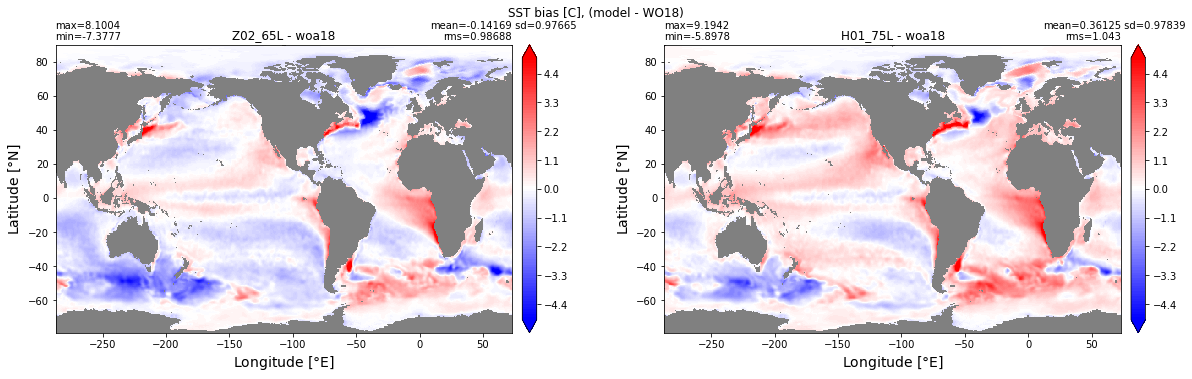

In [15]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5.3))
ax1 = ax.flatten()
temp_mom1 = np.ma.masked_invalid(sst[0].values)
temp_mom2 = np.ma.masked_invalid(sst[1].values)
temp_mom_obs = np.ma.masked_invalid(obs_temp_mom['theta0'][0,:].values)
xyplot(temp_mom1-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, 
         title=str(labels[0]+' - woa18'), axis=ax1[0], 
         clim=(-5,5), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

xyplot(temp_mom2-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, 
         title=str(labels[1]+' - woa18'), axis=ax1[1], 
         clim=(-5,5), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

plt.suptitle('SST bias [C], (model - WO18)')  

fname = 'sst_bias.png'
plt.savefig(fname, bbox_inches='tight',dpi=300)

### Mean SSH bias

In [45]:
# load WOA18 data for MOM6
aviso_path = '/glade/work/gmarques/cesm/datasets/Aviso/'
ssh_aviso = xr.open_dataset(aviso_path+'mean_ssh_yearly_climatology_remaped_to_tx0.6v1.nc')

ssh_aviso = ssh_aviso.assign_coords({"geolon": (("latitude","longitude"), grd.geolon)})
ssh_aviso = ssh_aviso.assign_coords({"geolat": (("latitude","longitude"), grd.geolat)})
ssh_aviso['longitude'] = grd.xh; ssh_aviso['latitude'] = grd.yh

In [18]:
def preprocess(ds):
  ''' Compute montly averages and return the dataset with variables'''
  variables=['SSH']
  return ds[variables].sel(time=slice(start, end))

ssh = []
for i in range(len(exps)):
  files = sorted(glob.glob(path+exps[i]+'/run/'+exps[i]+'.mom6.hm_*.nc'))[0:-1]

  ds = xr.open_mfdataset(files,
        parallel=True,
        concat_dim="time",
        combine="nested",
        preprocess=preprocess,
        chunks={'time': 1},)
    
  ssh.append(ds.SSH.mean(dim='time'))

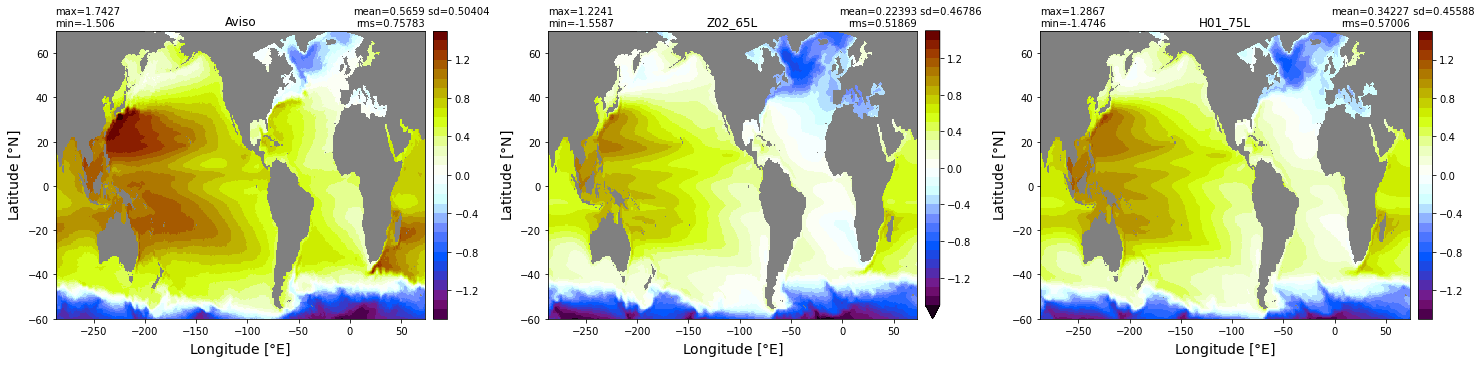

In [54]:
%matplotlib inline

area = grd_xr.area_t.sel(yh=slice(-60,70)).values
geolat = grd_xr.geolat.sel(yh=slice(-60,70)).values
geolon = grd_xr.geolon.sel(yh=slice(-60,70)).values

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5.3))
ax1 = ax.flatten()

ssh_mom1 = np.ma.masked_invalid(ssh[0].sel(yh=slice(-60,70)).values)
ssh_mom2 = np.ma.masked_invalid(ssh[1].sel(yh=slice(-60,70)).values)
aviso = np.ma.masked_invalid(ssh_aviso['adt'].sel(latitude=slice(-60,70)).values)
xyplot(aviso, geolon, geolat, area, 
         title='Aviso', axis=ax1[0], extend='neither',
         clim=(-1.5,1.5), nbins=30, centerlabels=True)

xyplot(ssh_mom1, geolon, geolat, area, 
         title=str(labels[0]), axis=ax1[1], 
         clim=(-1.5,1.5), nbins=30, centerlabels=True)

xyplot(ssh_mom2, geolon, geolat, area, 
         title=str(labels[1]), axis=ax1[2], 
         clim=(-1.5,1.5), nbins=30, centerlabels=True)

fname = 'mean_ssh.png'
plt.savefig(fname, bbox_inches='tight',dpi=300)

### Global mean bias versus time

In [63]:
ds = xr.open_dataset('../../'+exps[1]+'/ncfiles/'+exps[1]+'_temp_bias.nc').sel(time=slice(start, end))
ds.temp_bias
ds.close()

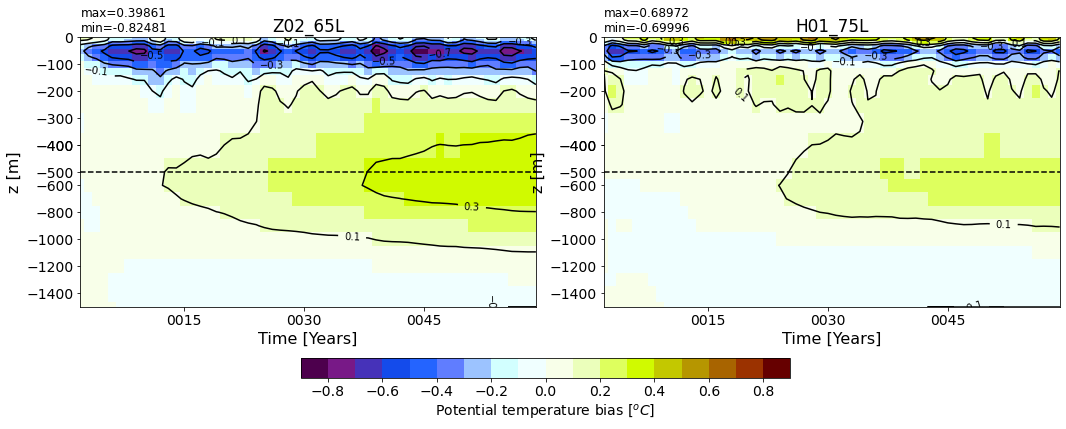

In [77]:
%matplotlib inline
start = '0001-01-01'
# only 4 plots

reg = 'Global'

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5.5))
#plt.suptitle(reg+' potential temperature bias [C], (model - WOA18)', y=0.96)
ax1 = ax.flatten()

clim=(-0.9, 0.9); clevs = np.linspace(clim[0],clim[1],10)
diff_levs = np.linspace(-0.02,0.02,10)

for i in range(len(exps)):
  splitscale =  [0., -500., -1500]
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc').sel(time=slice(start, end))
  dummy = np.ma.masked_invalid(ds.sel(region=reg).temp_bias.values)
  
    
  C1 = np.ma.masked_invalid(ds.sel(region=reg).temp_bias.values)
  cb1 = ztplot(C1, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, 
        axis=ax1[i], title=labels[i], extend='both', colormap='dunnePM', zlabel='z',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
  

    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.88, wspace=0.15)

cbar_ax1 = fig.add_axes([0.28, 0.02, 0.4, 0.05])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'Potential temperature bias [$^oC$]', fontsize=14)


fname = 'global_temp_bias.png'.format(reg)
plt.savefig(fname, bbox_inches='tight',dpi=300)